In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
##### import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

In [3]:
import cv2

In [4]:
video_frame_samples_dirs = [x[0] for x in os.walk("../data/video_ocr_results")][1:]

In [5]:
video_frame_samples_dirs

[]

#### loading ocr results and generate features

In [6]:
def create_img_df(image_dir: str):
    img_files = list(Path(image_dir).glob("*.jpg"))
    img_file_dict = {int(file.name.split(".")[0]): cv2.imread(str(file), cv2.IMREAD_GRAYSCALE) 
                 for file in img_files}
    total_pixals = img_file_dict[0].shape[0] * img_file_dict[0].shape[1]
    
    img_keys = sorted(img_file_dict)
    diff_dict = {}
    for index in range(len(img_keys)-1):
        diff_pixal = np.sum(img_file_dict[img_keys[index+1]] != img_file_dict[img_keys[index]])
        diff_percent = np.round(diff_pixal/2073600,3)
        diff_dict[img_keys[index+1]] = {'diff_pixal':diff_pixal, 'diff_percent':diff_percent}
    diff_df = pd.DataFrame.from_dict(diff_dict, orient='index').reset_index()
    return diff_df

In [7]:
import os 
import sys



import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image


from paddleocr import PaddleOCR
ocr = PaddleOCR(rec_model_dir="C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/models/en_number_mobile_v2.0_rec_infer/",
               det_model_dir="C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/ch_ppocr_server_v2.0_det_infer/",
                rec_char_dict_path="C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/ppocr/utils/en_dict.txt"
               )

def img_resize(img, scale: int=60):
    scale_percent = 60 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

Namespace(cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\alistar/.paddleocr/cls', cls_thresh=0.9, det=True, det_algorithm='DB', det_db_box_thresh=0.5, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.6, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/ch_ppocr_server_v2.0_det_infer/', drop_score=0.5, enable_mkldnn=False, gpu_mem=8000, image_dir='', ir_optim=True, label_list=['0', '180'], lang='ch', max_text_length=25, rec=True, rec_algorithm='CRNN', rec_batch_num=6, rec_char_dict_path='C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/ppocr/utils/en_dict.txt', rec_char_type='ch', rec_image_shape='3, 32, 320', rec_model_dir='C:/Users/alistar/Desktop/ds/PaddleOCR-release-2.1/models/en_number_mobile_v2.0_rec_infer/', use_angle_cls=False, use_dilation=False, use_gpu=True, use_pdserving=False, use_space_char=

In [8]:
import json
import spacy
nlp = spacy.load('en_core_web_sm')

In [9]:
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [10]:
video_ocr_paths = list(Path("../data/video_ocr_results").glob("*.json"))

In [1]:
video_ocr_paths[1]

NameError: name 'video_ocr_paths' is not defined

In [12]:
with open(video_ocr_paths[1].absolute(), 'r') as file:
    test_ocr_results = json.load(file)

In [13]:
def get_paragraph(ocr_result: list, threshold: float=0.9):
    return " ".join(list(map(lambda lst: lst[-1][0],filter(lambda lst: lst[-1][-1] >threshold, ocr_result))))

In [14]:
from collections import OrderedDict

In [39]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    if union == 0:
        print(list1)
        print(list2)
        return 0
    return float(intersection) / union

from functools import lru_cache

def lev_dist(a, b):
    '''
    This function will calculate the levenshtein distance between two input
    strings a and b
    
    params:
        a (String) : The first string you want to compare
        b (String) : The second string you want to compare
        
    returns:
        This function will return the distnace between string a and b.
        
    example:
        a = 'stamp'
        b = 'stomp'
        lev_dist(a,b)
        >> 1.0
    '''
    
    @lru_cache(None)  # for memorization
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)

def lev_dist(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [37]:
def get_diff_df(test_ocf_result: dict):
    test_ocr_paragraph = {int(frame): get_paragraph(ocr_result) for frame, ocr_result in test_ocr_results.items()}
    test_ocr_paragraph = OrderedDict(test_ocr_paragraph)
    img_keys = sorted(test_ocr_paragraph)
    img_dict = {key: nlp(paragraph) for key, paragraph in test_ocr_paragraph.items()}


    img_keys = sorted(img_dict)
    diff_dict = {}
    for index in range(1, len(img_keys)):
        doc1 = img_dict[img_keys[index]]
        doc2 = img_dict[img_keys[index-1]]
        dissimilarity = 1 - doc1.similarity(doc2)


        paragraph1 = test_ocr_paragraph[img_keys[index]].lower().split(" ")
        paragraph2 = test_ocr_paragraph[img_keys[index-1]].lower().split(" ")
        similarity = jaccard(paragraph1, paragraph2)
        jaccard_dissimilarity = 1 - similarity
        frame_token_ct = len(paragraph2)
        word_dissim = np.abs(len(paragraph1) - len(paragraph2))/max(len(paragraph1), len(paragraph2))
        
        
        paragraph1 = list(test_ocr_paragraph[img_keys[index]].lower())
        paragraph2 = list(test_ocr_paragraph[img_keys[index-1]].lower())
        similarity = jaccard(paragraph1, paragraph2)
        jaccard_letter_dissimilarity = 1 - similarity

        letter_dissim = np.abs(len(paragraph1) - len(paragraph2))/max(len(paragraph1), len(paragraph2))

        #lev dist
        try:
            if len(paragraph1) > 0:
                pargraph_lev_dist = lev_dist(paragraph1, paragraph2)/len(paragraph1)
            else:
                pargraph_lev_dist = lev_dist(paragraph1, paragraph2)
        except RecursionError:
            pargraph_lev_dist = 1.1
        
        diff_dict[img_keys[index]] = {'dissimilarity': dissimilarity, 'jaccard': jaccard_dissimilarity,
                                        'jaccard_letter':jaccard_letter_dissimilarity,
                                       'frame_token_ct': frame_token_ct,
                                      'lev_dis':pargraph_lev_dist,
                                       'word_dis': word_dissim,
                                       'letter_dissim': letter_dissim}


    diff_df = pd.DataFrame.from_dict(diff_dict, orient='index').reset_index()
    return diff_df

In [40]:
diff_df_dict = dict()
for video_ocr_path in video_ocr_paths:
    file_name = video_ocr_path.name.split(".")[0]
    
    print(video_ocr_path)
    with open(video_ocr_path.absolute(), 'r') as file:
        test_ocr_results = json.load(file)
    diff_df_dict[file_name] = get_diff_df(test_ocr_results )

..\data\video_ocr_results\test_video_0.json
[]
[]
..\data\video_ocr_results\test_video_1.json
[]
[]
[]
[]
[]
[]
[]
[]
..\data\video_ocr_results\test_video_10.json
..\data\video_ocr_results\test_video_11.json
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


test_video_0


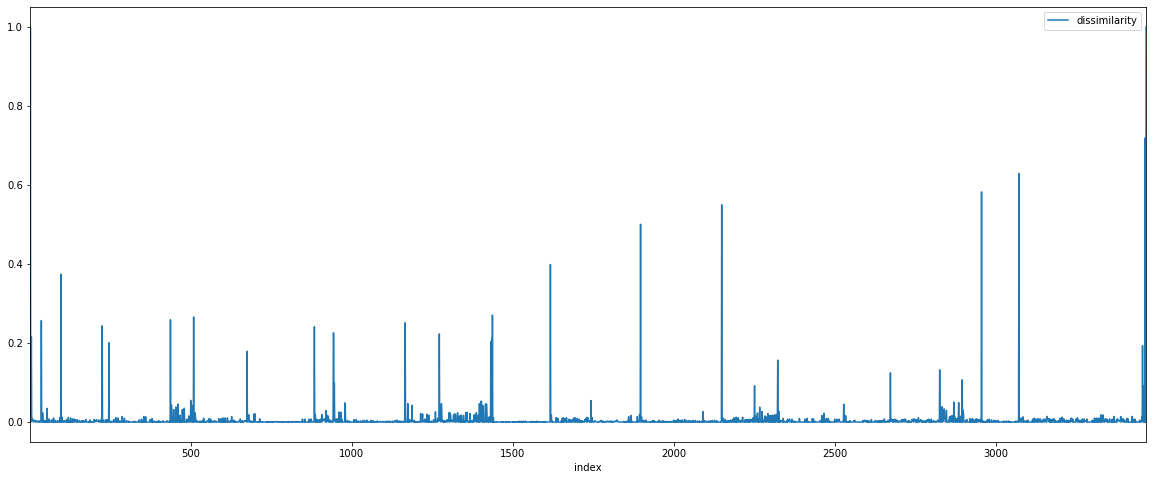

test_video_1


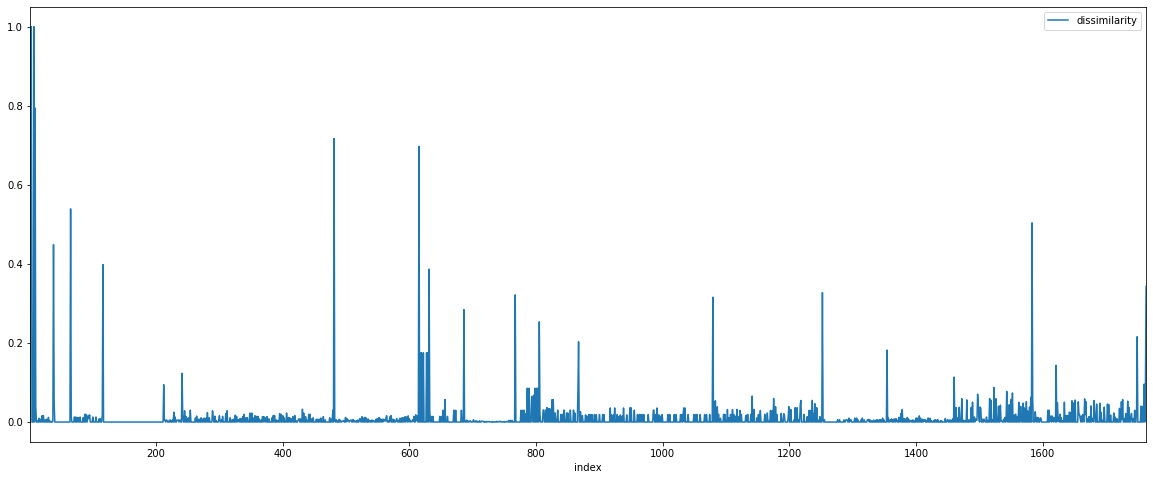

test_video_10


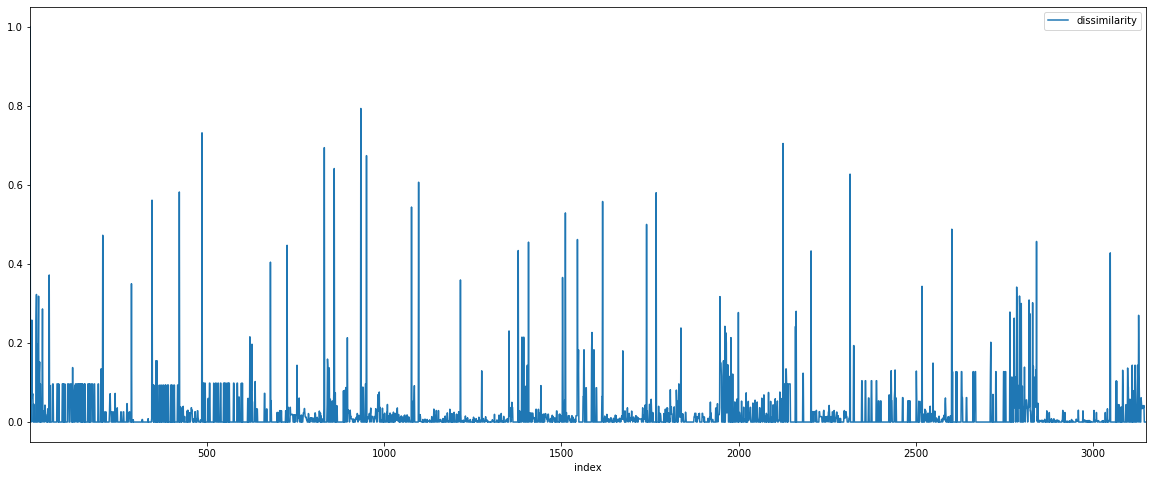

test_video_11


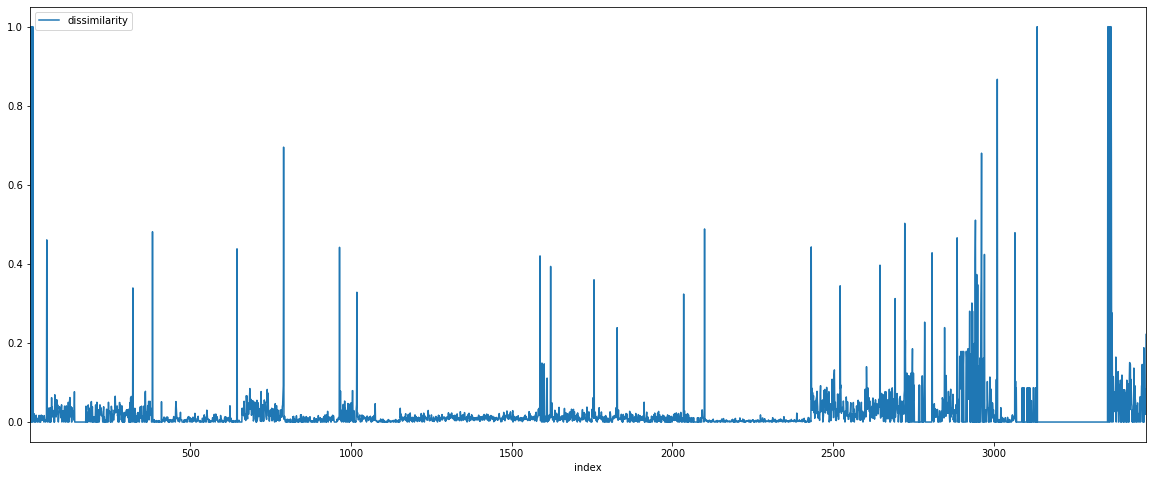

test_video_12


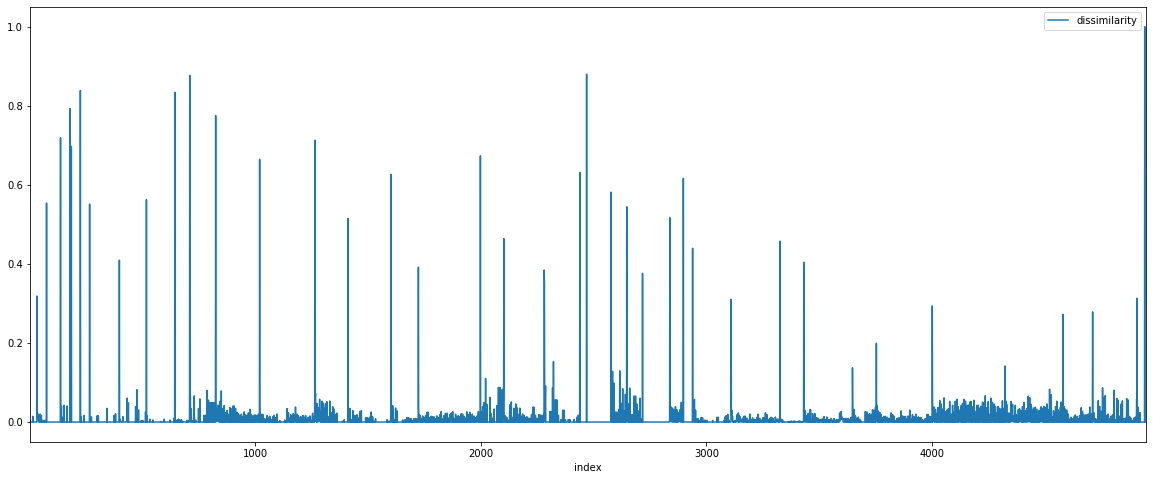

test_video_13


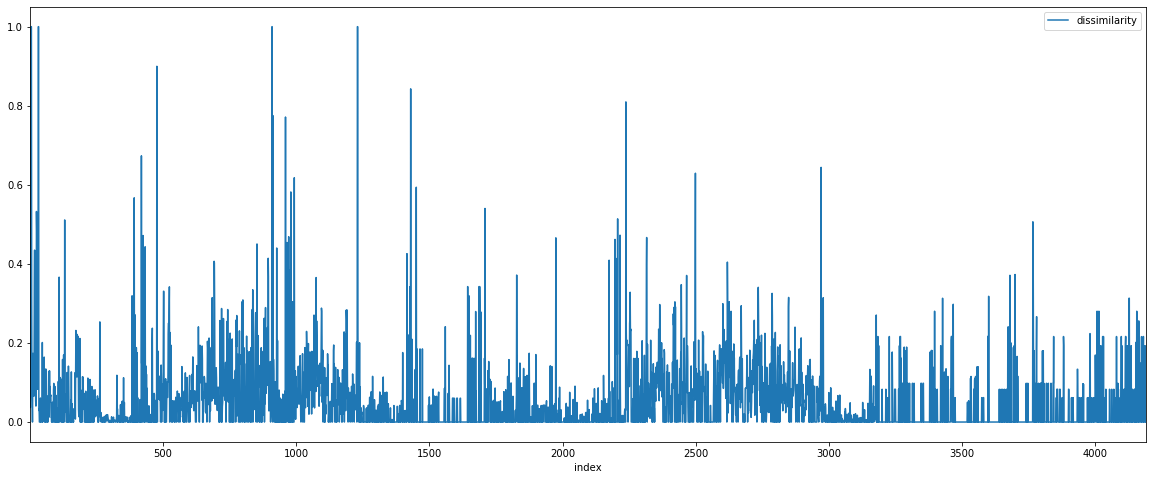

test_video_14


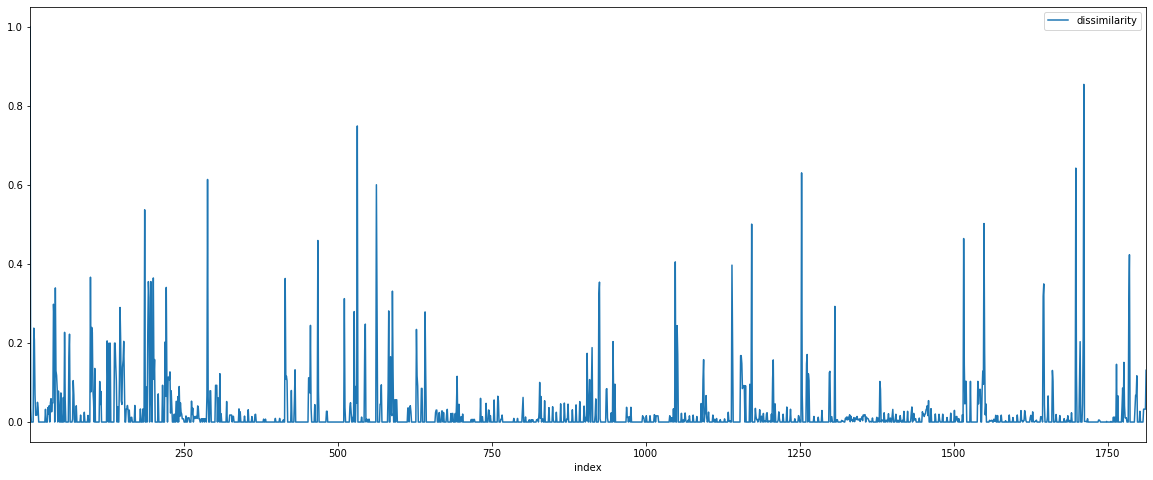

test_video_15


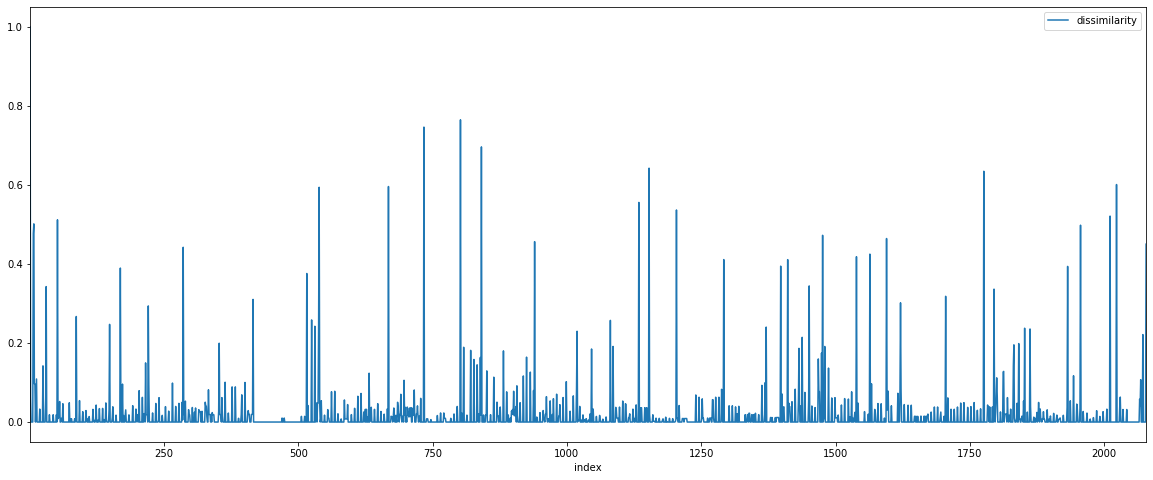

test_video_16


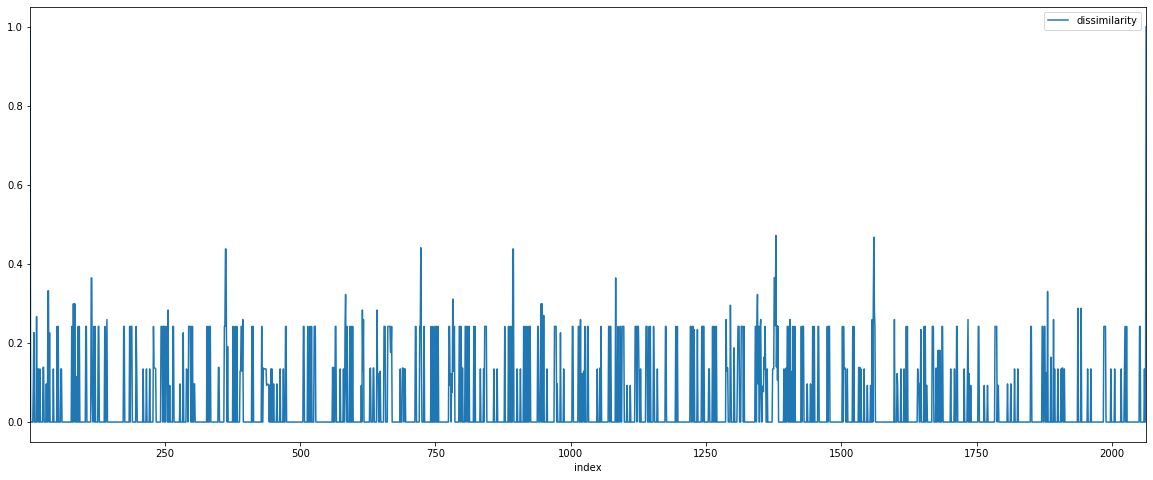

test_video_17


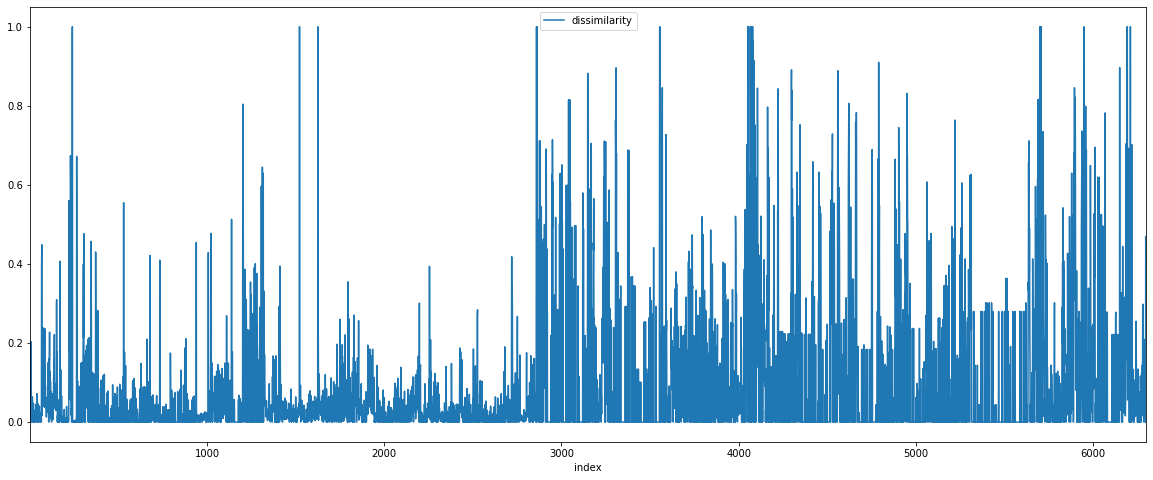

test_video_18


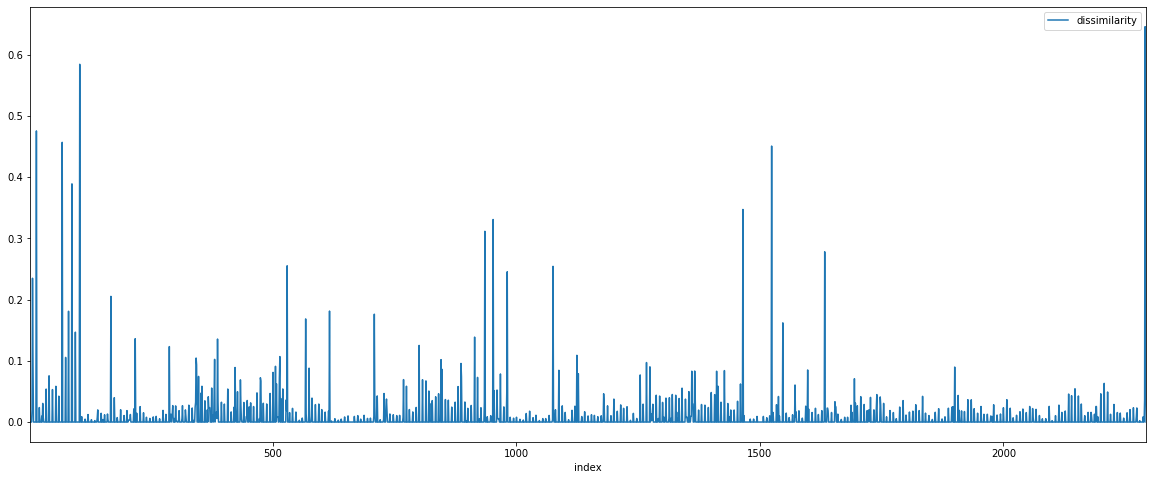

test_video_19


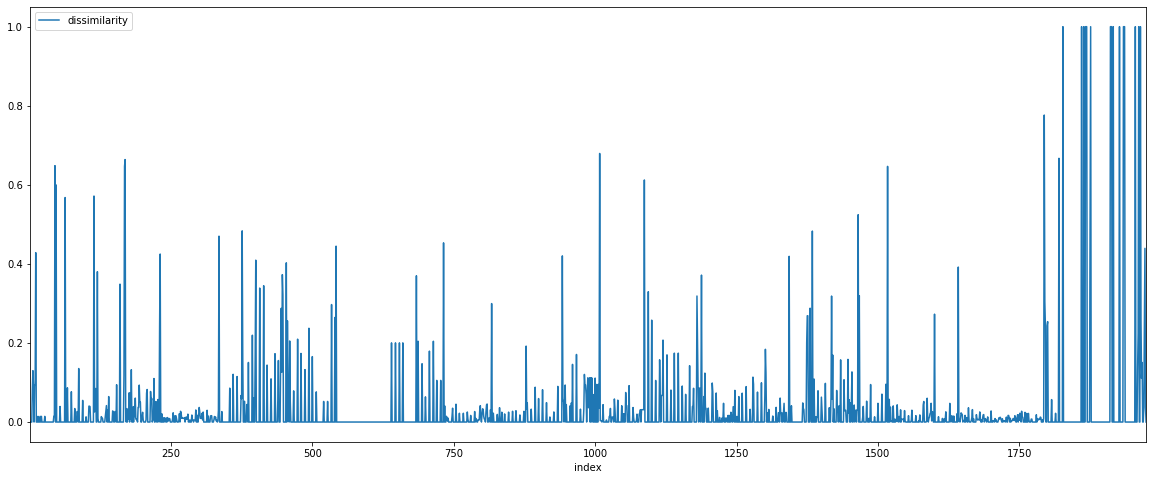

test_video_2


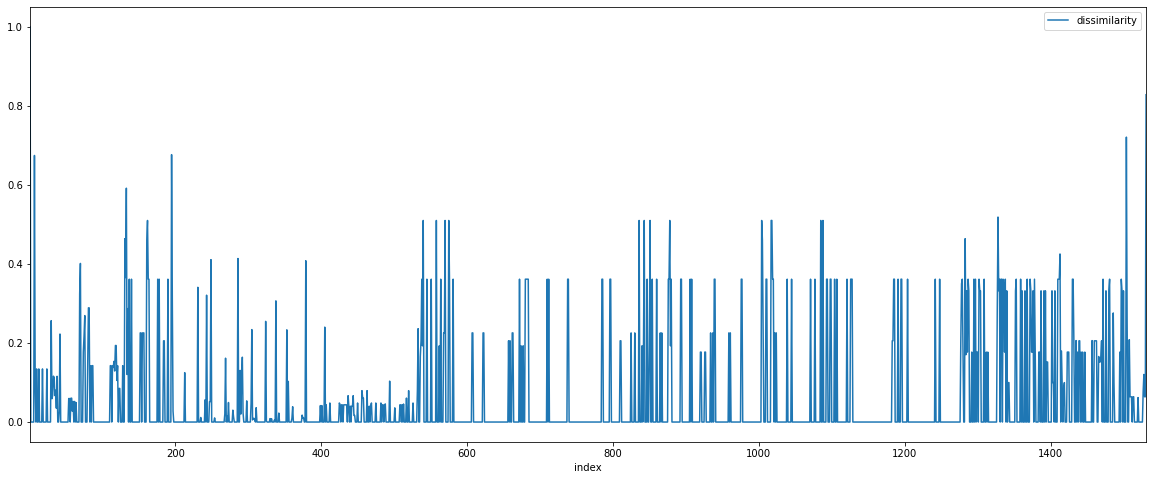

test_video_20


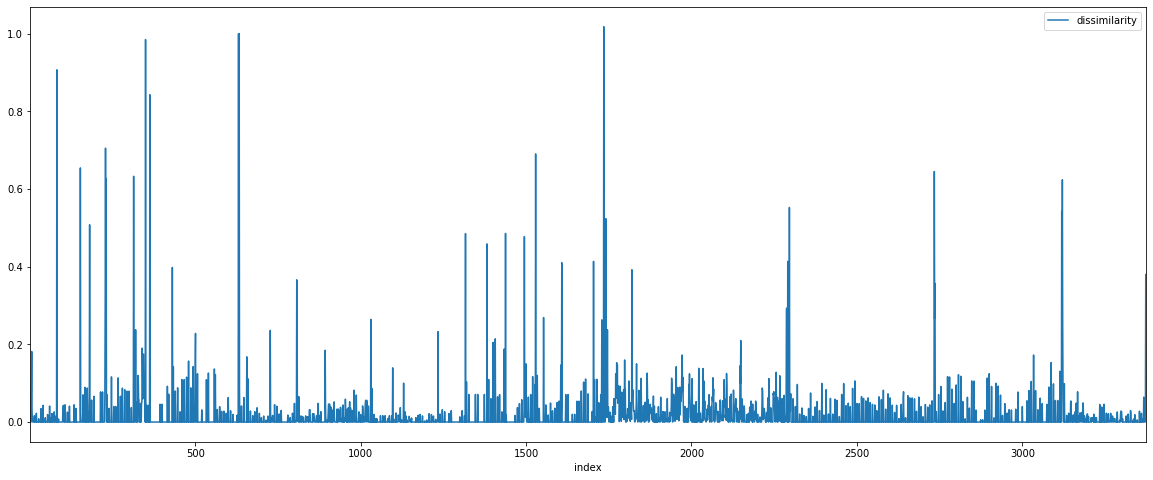

test_video_3


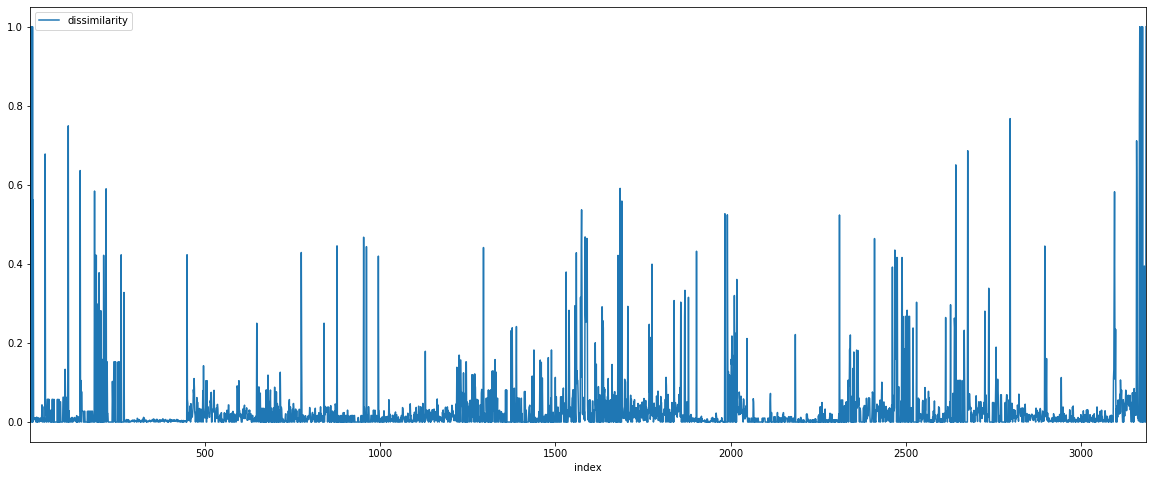

test_video_4


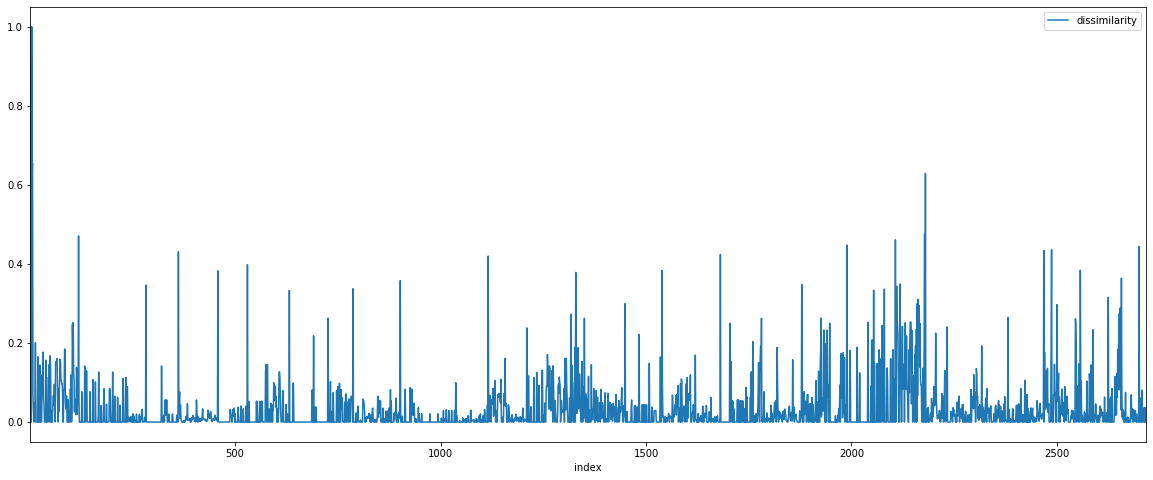

test_video_5


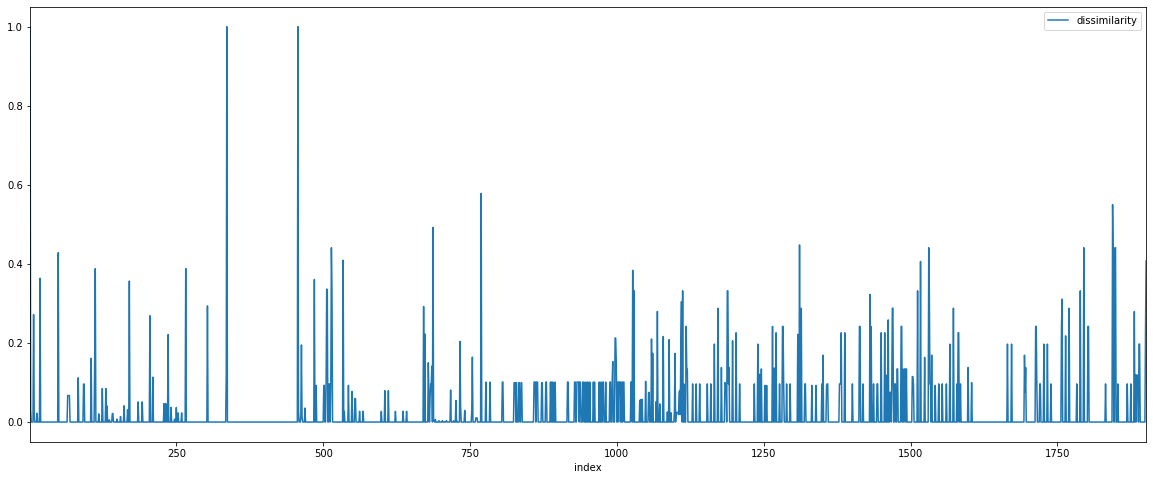

test_video_6


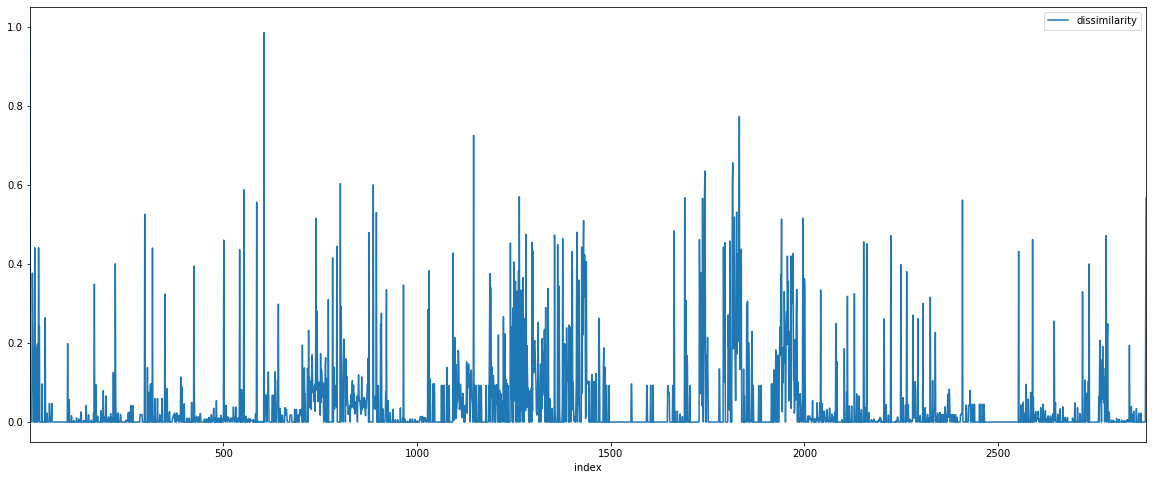

test_video_7


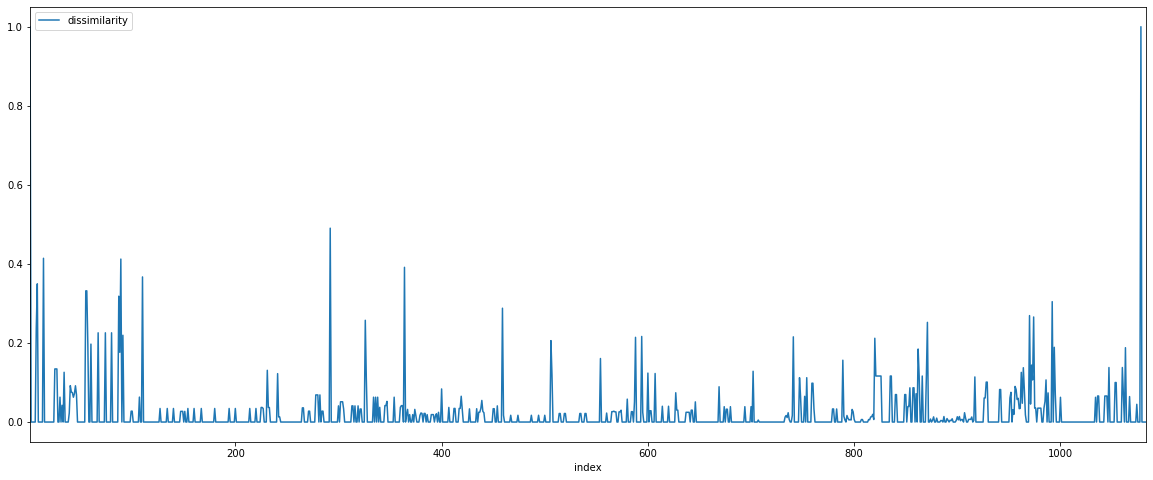

test_video_8


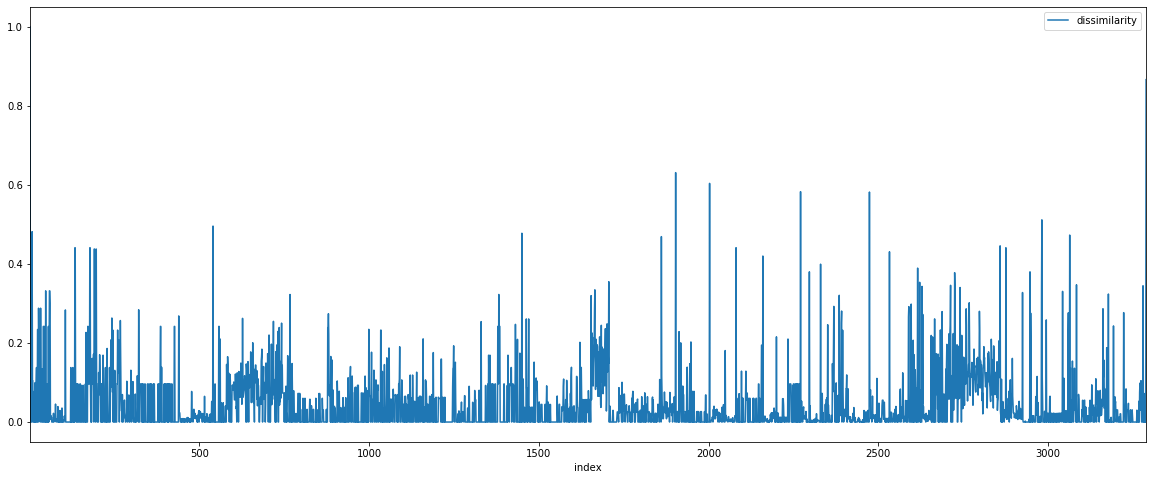

test_video_9


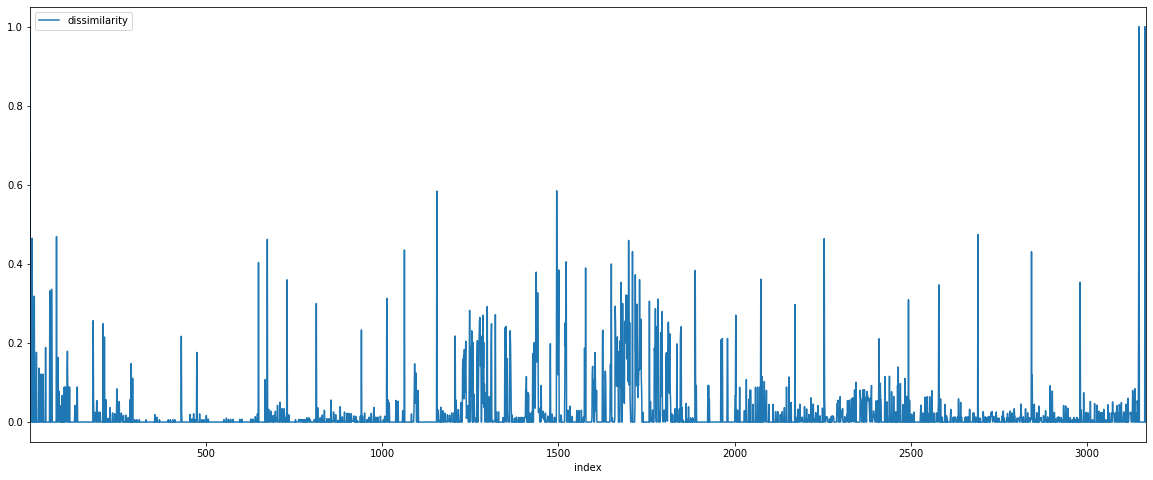

In [41]:
for file_name, diff_df in diff_df_dict.items():
    print(file_name)
    diff_df['min'] = diff_df['index']/60
    diff_df.plot(x='index', y='dissimilarity',figsize=(20,8))
    plt.show()

In [21]:
diff_df = diff_df_dict['test_video_11']

In [22]:
with open(video_ocr_paths[2].absolute(), 'r') as file:
    test_ocr_results = json.load(file)

In [23]:
get_paragraph(test_ocr_results['840'])

'STANDARDIZE SIGNATURE BYTHECOMMUNITY O FORTHECOMMUNITY FORMATTING'

In [24]:
get_paragraph(test_ocr_results['841'])

'STANDARDIZE SIGNATURE BY THE COMMUNITY O FORTHECOMMUNITY FORMATTING'

In [25]:
get_paragraph(test_ocr_results['842'])

'STANDARDIZE SIGNATURE BY THE COMMUNITY O FORTHECOMMUNITY FORMATTING'

In [26]:
lev_dist(get_paragraph(test_ocr_results['840']),
         get_paragraph(test_ocr_results['841']))/len(get_paragraph(test_ocr_results['842']))

0.029850746268656716

In [27]:
pd.cut(diff_df['dissimilarity'], bins=np.arange(-0.1, 1.1, 0.1)).value_counts()

(0.0, 0.1]     2386
(-0.1, 0.0]     967
(0.1, 0.2]       70
(0.4, 0.5]       12
(0.3, 0.4]       12
(0.9, 1.0]       11
(0.2, 0.3]        9
(0.6, 0.7]        3
(0.5, 0.6]        2
(0.8, 0.9]        1
(0.7, 0.8]        1
(1.0, 1.1]        0
Name: dissimilarity, dtype: int64

In [28]:
def jaccard_verbose(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    print(intersection)
    union = (len(list1) + len(list2)) - intersection
    print(union)
    if union == 0:
        print(list1)
        print(list2)
        return 0
    return float(intersection) / union

In [46]:
diff_df.query("dissimilarity >= 0.1 and letter_dissim >= 0.1").shape

(163, 9)

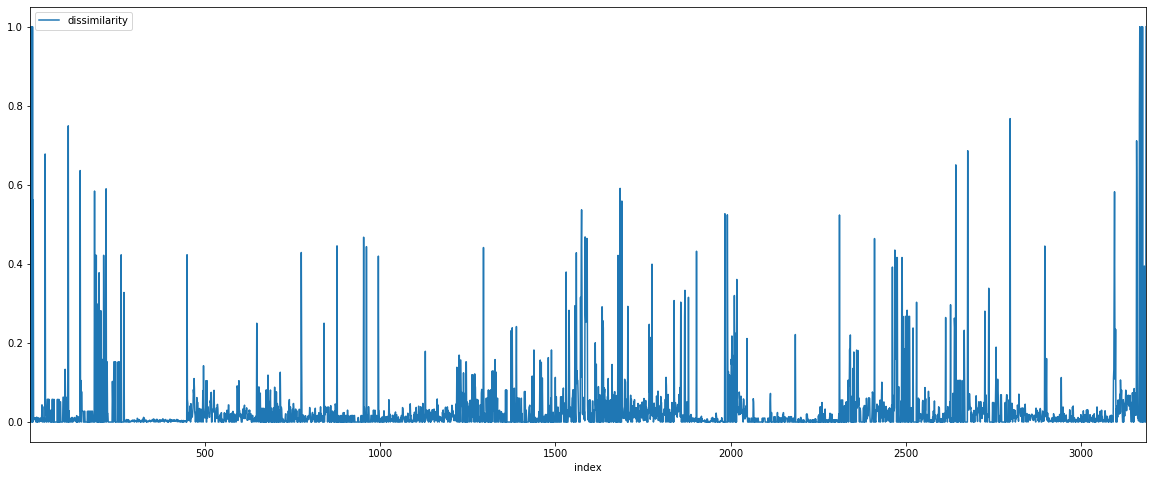

In [50]:
diff_df.plot(x='index', y='dissimilarity',figsize=(20,8))

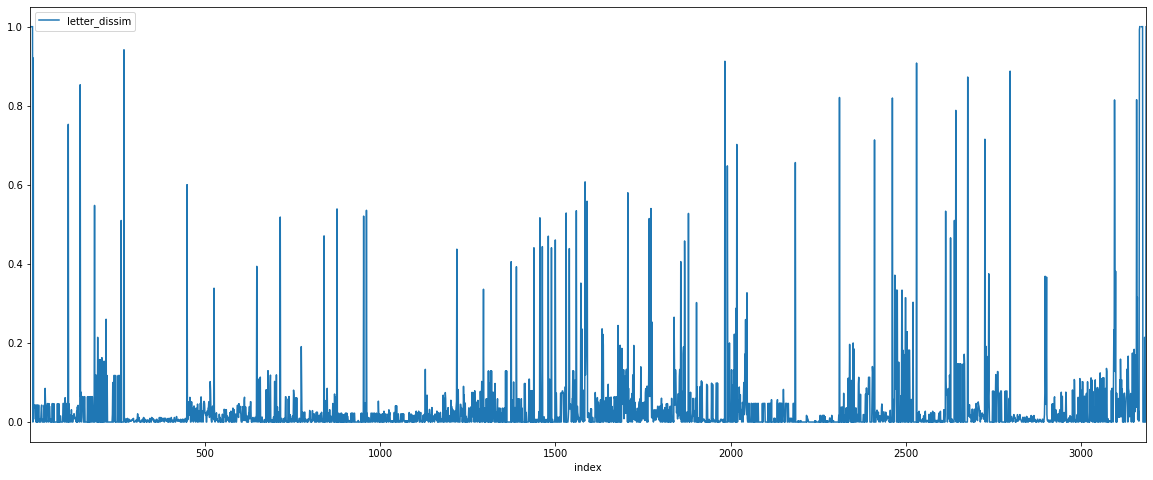

In [51]:
diff_df.plot(x='index', y='letter_dissim',figsize=(20,8))

In [47]:
diff_df = diff_df_dict['test_video_3']
print(diff_df.query("dissimilarity >= 0.1 and letter_dissim >= 0.1").shape)
diff_df.query("dissimilarity >= 0.1 and letter_dissim >= 0.1")

(163, 9)


,index,dissimilarity,jaccard,jaccard_letter,frame_token_ct,lev_dis,word_dis,letter_dissim,min
2,3,1.000000,1.000000,1.000000,1,1.000000,0.500000,1.000000,0.050000
3,4,1.000000,1.000000,1.000000,2,10.000000,0.500000,1.000000,0.066667
7,8,1.000000,1.000000,1.000000,1,1.000000,0.500000,1.000000,0.133333
9,10,0.561958,0.875000,0.928571,2,0.920863,0.875000,0.920863,0.166667
109,110,0.749206,0.868421,0.961538,21,0.775100,0.676923,0.753012,1.833333
143,144,0.636092,0.986842,0.962521,67,5.987179,0.850746,0.853107,2.400000
184,185,0.584258,0.833333,0.847826,9,1.484848,0.444444,0.547945,3.083333
186,187,0.421824,0.727273,0.679245,5,0.108108,0.444444,0.108108,3.116667
189,190,0.421824,0.727273,0.679245,9,0.121212,0.444444,0.108108,3.166667
193,194,0.298382,0.727273,0.706897,5,0.214286,0.444444,0.214286,3.233333


In [53]:
for video_name, diff_df in diff_df_dict.items():
    diff_df.to_csv(os.path.join( "../data/video_frame_obj", video_name+".csv"), index=False)